# Learning from linear data (plus noise)

Welcome to this notebook.

I'm Paulo Abelha and this ntoebook is available at my GitHub http://ww.github.com/pauloabelha/notebooks

I made this as part of my own studies in Machine Learning.

The idea is start simple, but principled and work our way up the abstractions.

Therefore we deal with the "hello world" of Machine Learning: Linear regression

All code in here is of my own authorship.

Main Resources:
- Wikipedia
- David Mackay's bible was a valuable resource: http://www.inference.org.uk/mackay/itila/book.html
- This great paper: MacKay, David JC. "Bayesian interpolation." Neural computation 4.3 (1992): 415-447.
- Another great book: http://www.gaussianprocess.org/gpml/
- Yet another great book: http://www.deeplearningbook.org/

In this notebook we compare four different Machine Learning approaches for fitting a function to noisy linear data
- Linear Regression
- Bayesian Linear Regression
- Neural Networks
- Gaussian Processes


p.s.: One interesting thing would be to implement our own Gaussian distribution sampler:

    http://www.alanzucconi.com/2015/09/16/how-to-sample-from-a-gaussian-distribution/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# for reproducibility
random_seed_ix = 1
np.random.seed(random_seed_ix)

**1.1 Helper Functions**

In [2]:
# X is originally a matrix of (n_pts,n_dis), but we encode the bias by adding a column of ones to it the linear model becomes just
# y = X*w isntead of y = X*w + b
# We also add the bias to the weight vector
def augment_with_bias(X,b,w):
    n_pts = X.shape[0]
    n_dims = X.shape[1]
    X_b = np.hstack((X,np.ones((n_pts,1))))
    w_b = np.append(w,np.full((1,1),b),axis=0)
    return X_b, w_b

In [3]:
# Decode data encoded by augment_with_bias to retrieve the original X, w matrices and the bias b
def disaugment_with_bias(X_b,w_b):
    X = X_b[:,:-1]
    b = w_b[-1,0]
    w = w_b[:-1,:]
    return X, w, b

In [4]:
# plot a cooolwarm surface given an m x n matrix Z with values
def my_plot_3Dsurf(range_x,range_y,Z,label_x = 'x',label_y = 'y', viewpoint = 111, fontsize_x = 18, fontsize_y = 18):
    x = np.linspace(range_x[0], range_x[1], Z.shape[0])
    y = np.linspace(range_y[0], range_y[1], Z.shape[1])
    xv, yv = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(viewpoint, projection='3d')
    ax.plot_surface(xv, yv, Z, cmap=cm.coolwarm)
    plt.xlabel(label_x, fontsize=fontsize_x)
    plt.ylabel(label_y, fontsize=fontsize_y)
    plt.show()

**1.1 - Linear Model for Generating Data**

Here we:
- Define our linear model plus noise
- Define the function for generating the data
- Plot the data and information about it (matrices' shapes and value for the weight w and bias b)

In [5]:
# the linear model y = X*w + b using the encoded bias
def linear_model(X,w,b = 0,noise_sigma = 0):
    n_pts = X.shape[0]
    X_b, w_b = augment_with_bias(X,b,w)
    noise_vec = np.random.normal(0,noise_sigma,(n_pts,1))    
    y = np.dot(X_b,w_b) + noise_vec
    # ensure y is a (n_pts,1) vector
    assert(y.shape[0] == n_pts)
    assert(y.shape[1] == 1)
    return y, noise_vec, X_b, w_b

In [6]:
# Generate Gaussian-noisy linear data plus
# X is (n_pts,n_dims), where n is number of examples and d is numebr of dimensions
# the bias is included in X as an extra column
# so the vector w also gets an extra element (always 1)
# y is (n_pts,1)
# currently this code is for one dimension only
def gen_Gauss_noisy_lin_data(n_pts, random_seed_ix = 1, plot_fig = 0):  
    # number of dimensions
    n_dims = 1
    # for reproducibility
    np.random.seed(random_seed_ix)
    # noise level (variance of Gaussian distribution for noise)
    noise_sigma = np.random.rand(1)*0.05
    # get X as a random matrix (with one xtra column for adding bias)
    X = np.random.rand(n_pts,n_dims)
    # add the bias by overwriting the extra column of X
    b = np.random.rand()
    # ensure w has only positive values (for more intuitive visualisation from left to right)
    w = abs(np.random.randn(n_dims,1))
    # get y
    y, noise_vec, X_b, w_b = linear_model(X,w,b,noise_sigma)
    if plot_fig:
        plt.scatter(X, y, color='k')
        plt.show()
    return (X_b, y, w_b, noise_vec)

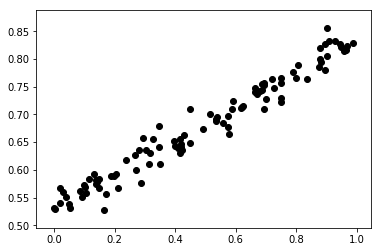

X_train shape (wth added bias) = (100, 2)
y_train shape = (100, 1)
w shape (with added bias) = (2, 1)
noise shape = (100, 1)
w = [[ 0.30620401]
 [ 0.5270581 ]]


In [12]:
# plot the data and information about it
n_pts = 100
X_train_b, y_train, w_b, noise = gen_Gauss_noisy_lin_data(n_pts,random_seed_ix,True)
print("X_train shape (wth added bias) = " + str(X_train_b.shape))
print("y_train shape = " + str(y_train.shape))
print("w shape (with added bias) = " + str(w_b.shape))
print("noise shape = " + str(noise.shape))
print("w = " + str(w_b))

**1.2 - Linear Regresion**

Here we:
- Define our loss function as mean squared errors
- Perform Linear Regresion on the generated data
- Plot the fit in data space
- Plot the loss function in parameter space

In [13]:
# mean squared error for our linear model
def my_mse(y_hat,y):
    m = y_hat.shape[1]
    mse = (1/m)*np.sum(np.power(y_hat-y,2))
    return mse    

In [14]:
# perform linear regression using mean squared error as loss function
# please, do go through the derivations in: http://www.deeplearningbook.org/contents/ml.html (Section 5.1.4)
def my_linear_regression(X_train,y_train):
    assert(X_train.shape[0] == y_train.shape[0])
    # separate the derivation into chunks for easier understanding
    a = np.linalg.inv(np.dot(X_train.T,X_train))
    b = np.dot(a,X_train.T)
    w_pred = np.dot(b,y_train) 
    # get predictions
    y_pred = np.dot(X_train,w_pred)
    assert(y_pred.shape == y_train.shape)
    # get mean squared error
    mse = my_mse(y_train,y_pred)
    return w_pred, y_pred, mse

Predicted w = [[ 0.30436506]]
Real w = [[ 0.30620401]]
Predicted b = 0.527058102258
Real b = 0.530357938757
Mean squared error = 0.0337736639937


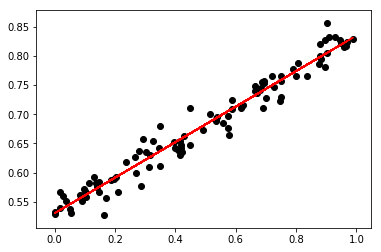

In [15]:
# call linear regression on our training data and get the real and predicted values for w and b, plotting the fit
w_pred, y_pred, mse = my_linear_regression(X_train_b,y_train)
X_train, w, b = disaugment_with_bias(X_train_b,w_b)
print("Predicted w = " + str(w_pred[:-1,:]))
print("Real w = " + str(w))
print("Predicted b = " + str(b))
print("Real b = " + str(w_pred[1,0]))
print("Mean squared error = " + str(mse))

plt.plot(X_train,y_pred, color = 'r')
plt.scatter(X_train, y_train, color = 'k')
plt.show()

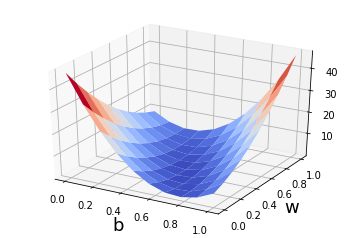

In [11]:
# get the mean squared errors for a range of w and b values and plot the error surface
n_iter = 10
w_curr = np.zeros((1,1))
mse_errors = np.zeros((n_iter,n_iter))
for i in range(n_iter):
    # force float by multiplying by 1.0
    w_curr[0,0] = 1.0*i/n_iter
    for j in range(n_iter):
         # force float by multiplying by 1.0
        b_curr = 1.0*j/n_iter
        y_hat, _, _, _ = linear_model(X_train,w_curr,b_curr)
        mse_errors[i,j] = my_mse(y_hat,y_train)
my_plot_3Dsurf([0, 1],[0, 1],mse_errors,'b','w')

Note that we were able to estimate quite closely the global minimum, but we don't have error bars nor any sort of probability distribution over the parameters
Try removing the noise form the linear model to see what happens

**1.2 Bayesian linear regression**